# League of legend data exploration & feature selection

data exploration & feature selection

1. histogram: find sparsed data, look at discrete & categorical data distribution
2. correlation map: find multicollinearity 
3. clustering (kmeans, DBSCAN, hierarchical)
4. feature selection (by models, score methods,forward feature selection) 

In [52]:
# import packages

import numpy as np
import pandas as pd
from pandas import value_counts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('data.csv')
data_cleaned = pd.read_csv('data_cleaned.csv')

In [14]:
data.columns

Index(['team_one_win', 'duration', 'type', 'team_one_barons',
       'team_two_barons', 'team_one_dragons', 'team_two_dragons',
       'team_one_rift_heralds', 'team_two_rift_heralds',
       'team_one_first_baron', 'team_one_first_blood', 'team_one_first_dragon',
       'team_one_first_inhibitor', 'team_one_first_rift_herald',
       'team_one_first_tower', 'team_one_assists', 'team_two_assists',
       'team_one_level', 'team_two_level', 'team_one_kills', 'team_two_kills',
       'team_one_obj_damage', 'team_two_obj_damage', 'team_one_deaths',
       'team_two_deaths', 'team_one_gold', 'team_two_gold',
       'team_one_double_kills', 'team_two_double_kills', 'team_one_damage',
       'team_two_damage', 'team_one_enemy_monsters_killed',
       'team_two_enemy_monsters_killed', 'team_one_cc_time',
       'team_two_cc_time', 'team_one_healing', 'team_two_healing',
       'team_one_champ_damage', 'team_two_champ_damage', 'team_one_cs',
       'team_two_cs', 'team_one_vision_score', 'team

In [15]:
data_cleaned.columns

Index(['team_one_win', 'duration', 'team_one_barons', 'team_two_barons',
       'team_one_dragons', 'team_two_dragons', 'team_one_rift_heralds',
       'team_two_rift_heralds', 'team_one_first_baron', 'team_one_first_blood',
       ...
       'team_two_mid_champ_(139.0, 144.0]',
       'team_two_mid_champ_(144.0, 148.0]',
       'team_two_mid_champ_(148.0, 149.0]',
       'team_two_bot_champ_(-0.001, 98.0]', 'team_two_bot_champ_(98.0, 109.0]',
       'team_two_bot_champ_(109.0, 117.0]',
       'team_two_bot_champ_(117.0, 123.0]',
       'team_two_bot_champ_(123.0, 128.0]',
       'team_two_bot_champ_(128.0, 132.0]',
       'team_two_bot_champ_(132.0, 133.0]'],
      dtype='object', length=172)

# Correlation map and histogram

In [22]:
# select distrete numeric column + categorical column, similar step as data preprocesing

data_numbers = data.select_dtypes(include=[np.number], exclude = [np.float])
unique = pd.DataFrame(data_numbers.nunique())
discrete_numeric_list = unique.index[unique[0] <= 50].tolist()
data_non_numeric_col = data.select_dtypes(exclude=[np.number]).columns.tolist()
discrete_colname = discrete_numeric_list + data_non_numeric_col
data_discrete = data[discrete_numeric_list + data_non_numeric_col]
unique = pd.DataFrame(data_discrete.nunique())

# when unique vlaue > 50, grouping them later
unique_grouping = unique.index[unique[0] > 50].tolist()

# when unique value > 20 and <= 50, use simple encoder
unique_le = unique.index[(unique[0] > 20) & (unique[0] <= 50)].tolist()

# when unique value <= 20, use onehog encoder
unique_onehog = unique.index[unique[0] <= 20].tolist()

In [25]:
len(unique_onehog)

32

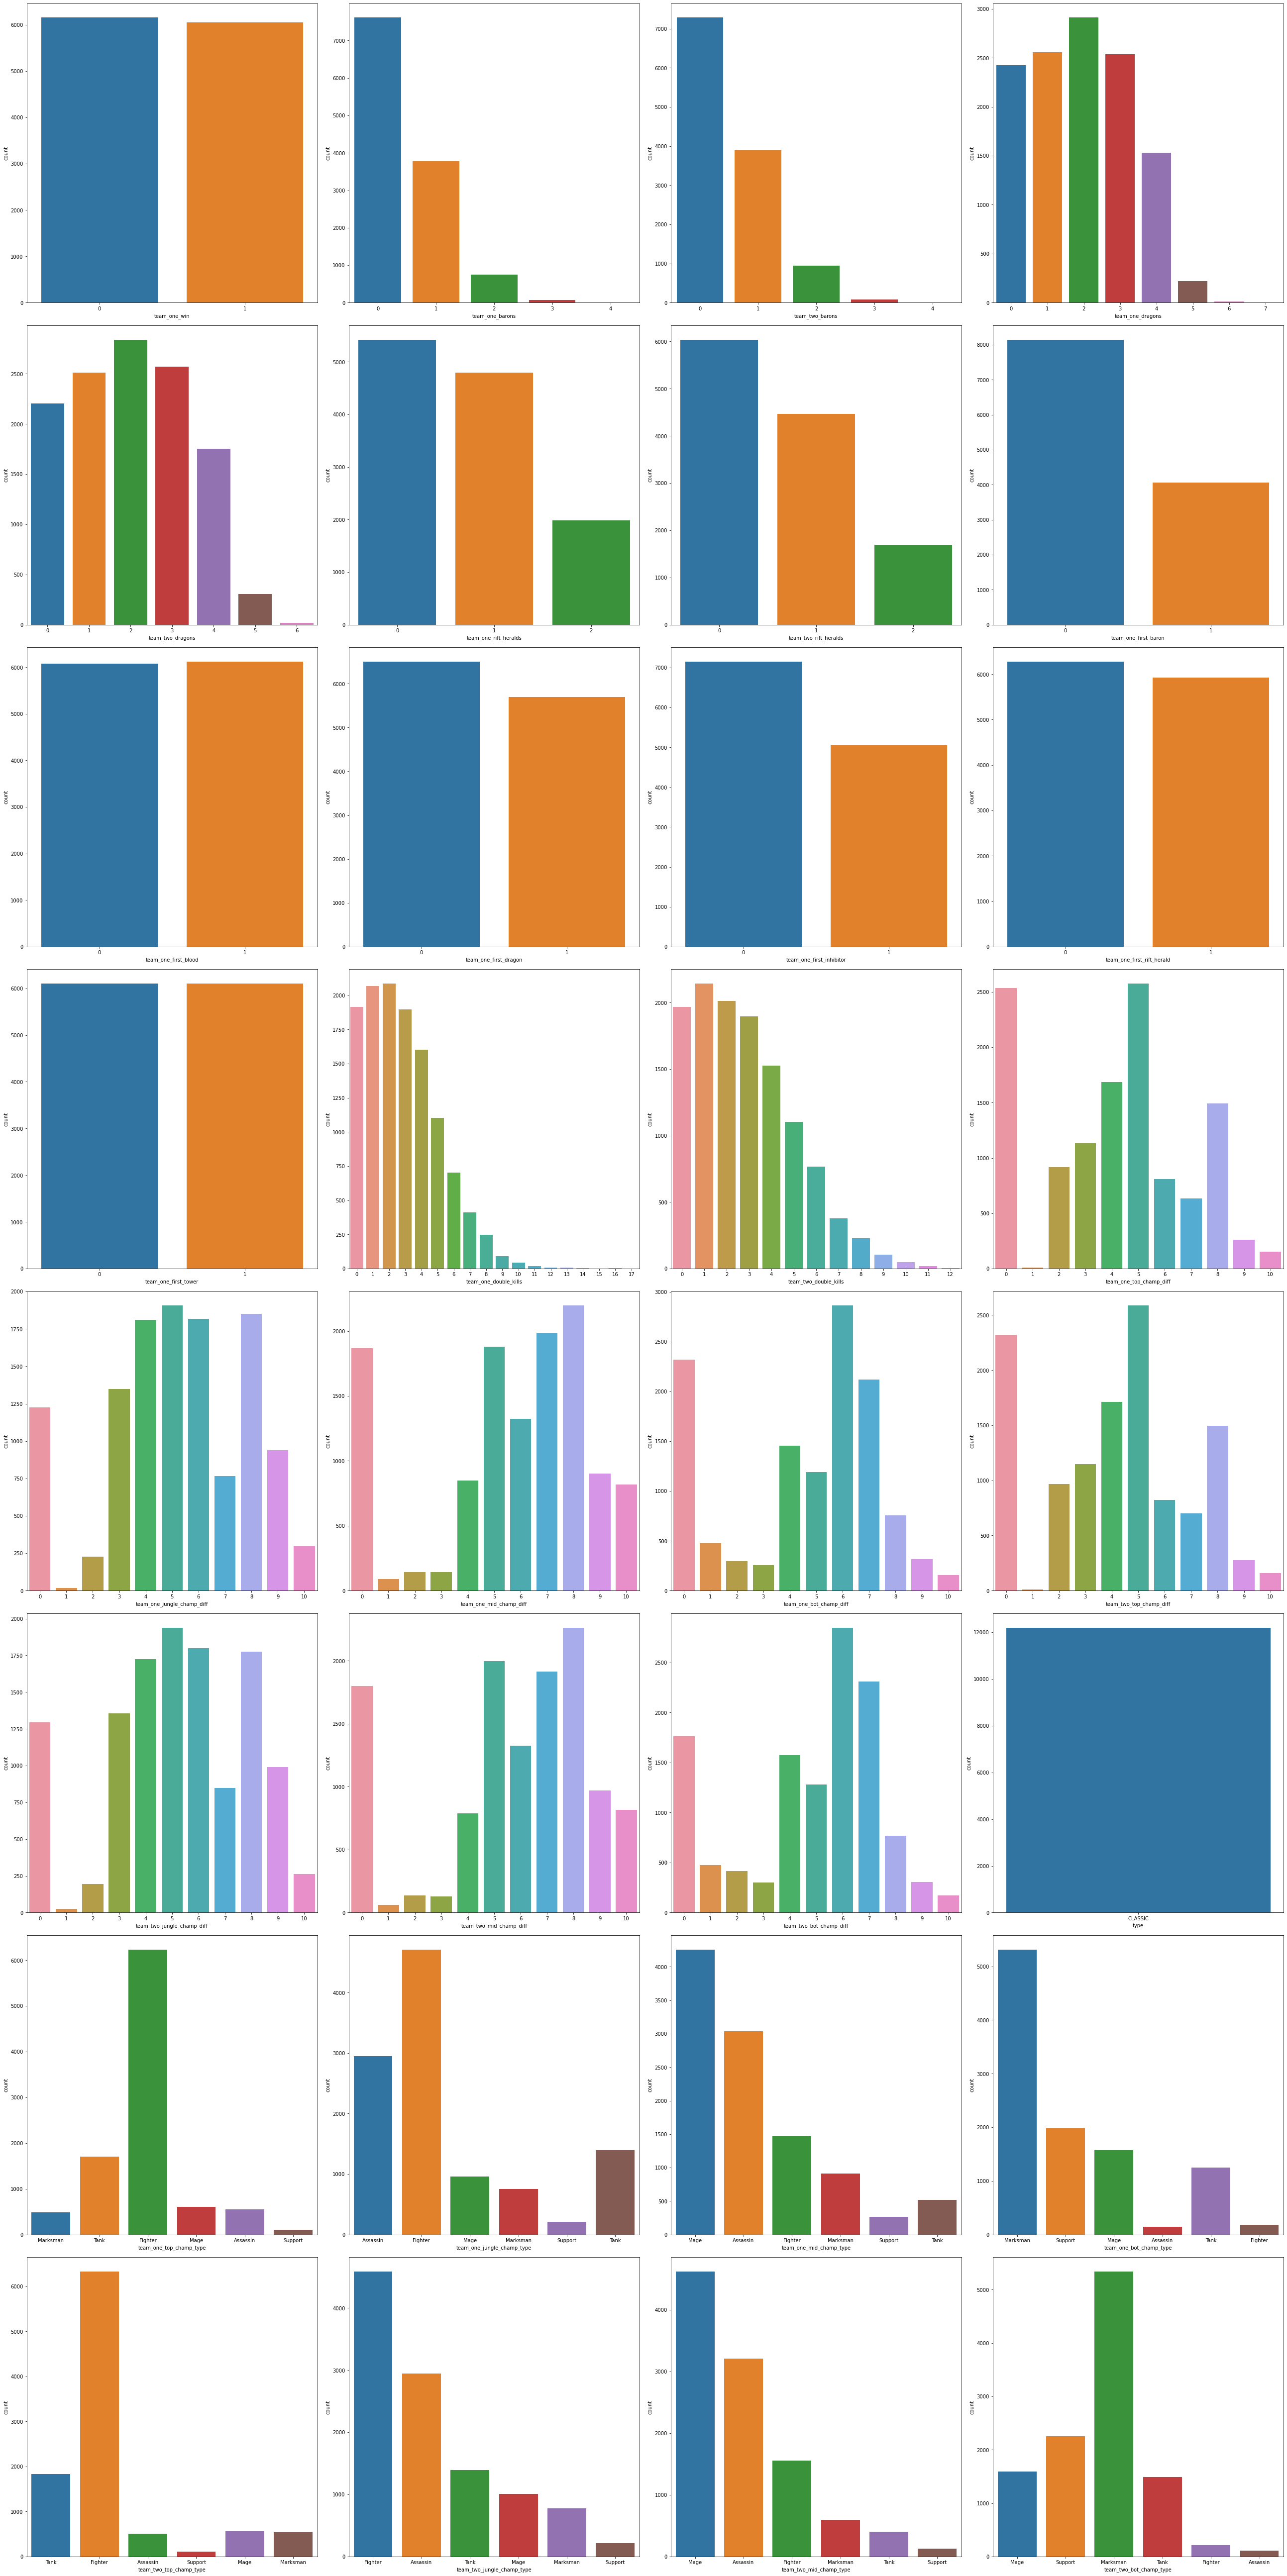

In [26]:
fig = plt.figure(figsize=(36,72))
for index,col in enumerate(unique_onehog):
    plt.subplot(8,4,index+1)
    sns.countplot(data[col_disnum_cat].loc[:,col].dropna())
fig.tight_layout(pad=1.0)

Looks like type is sperased data, delete it.

In [33]:
del data_cleaned['type_CLASSIC']

In [36]:
data_numbers = data.select_dtypes(include=[np.number], exclude = [np.float])

unique = pd.DataFrame(data_numbers.nunique())
continuous_list = unique.index[unique[0] > 50].tolist() # when unique values > 50, consider as continous variable, such as duration is the total time for the game
len(continuous_list)

27

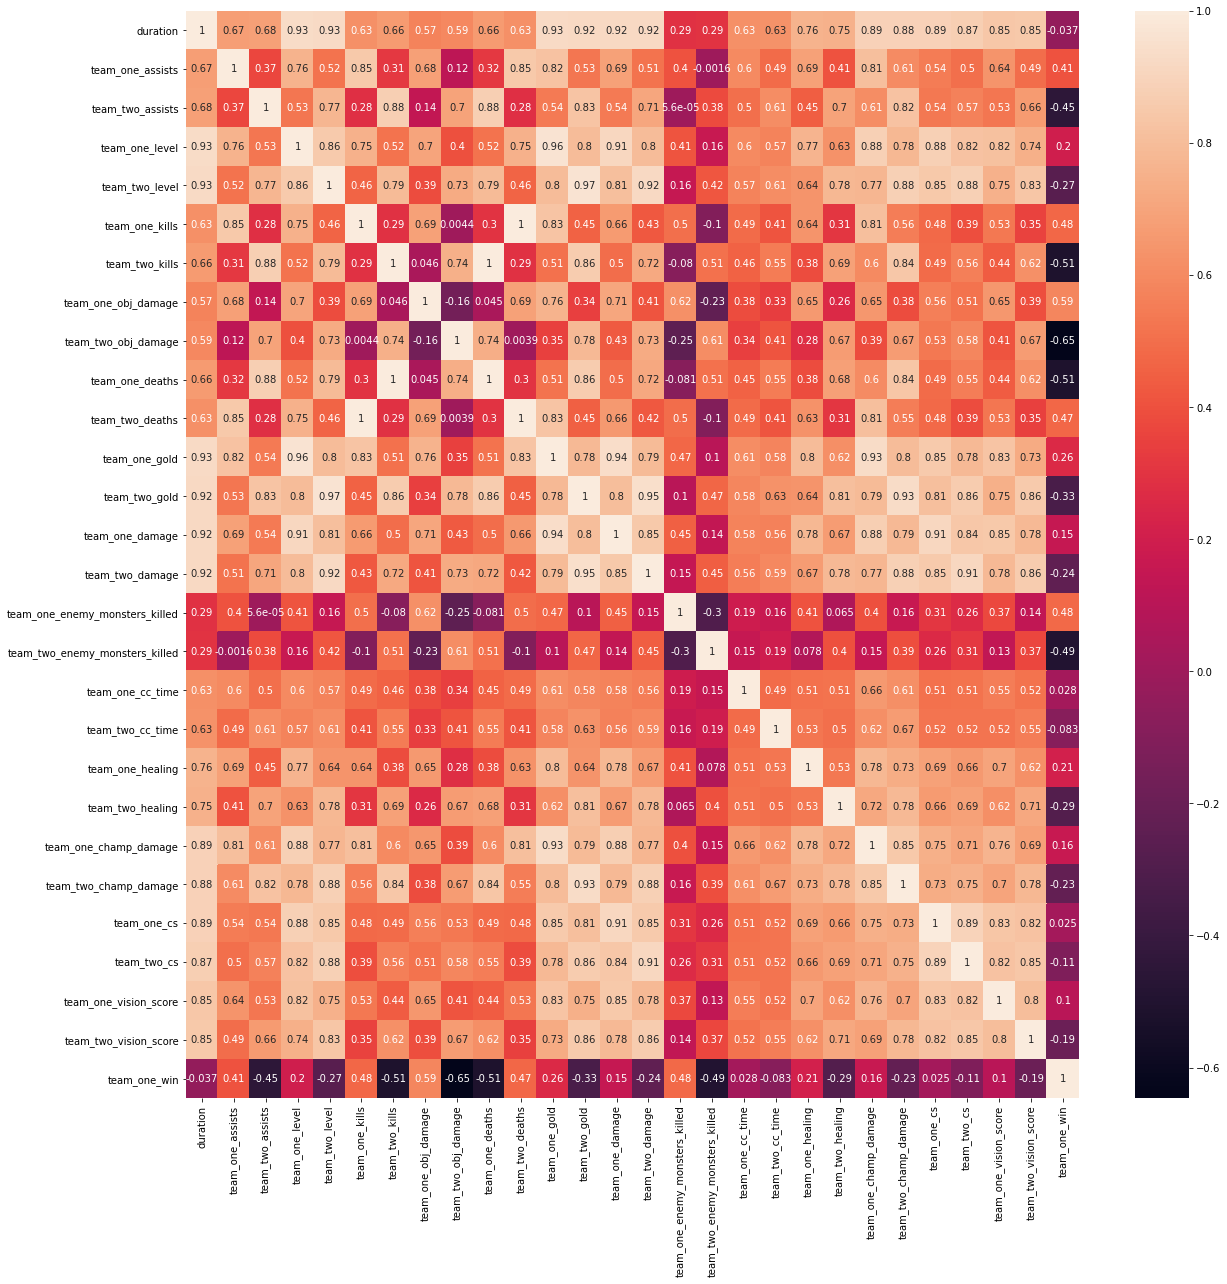

In [45]:
plt.figure(figsize=(20, 20))
sns.heatmap(data[continuous_list + ['team_one_win']].corr(), annot = True)

In [46]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(data, .95)

team_one_level  team_one_gold      0.964718
team_two_level  team_two_gold      0.965946
team_two_kills  team_one_deaths    0.999336
team_one_kills  team_two_deaths    0.999521
team_one_win    team_one_win            NaN
dtype: float64

find pairs of correlation above 0.95 , delete one of them to reduce multicollinearity 

In [50]:
data_cleaned.drop(['team_one_gold', 'team_two_gold', 'team_one_deaths', 'team_two_deaths'], axis = 1, inplace = True)

3. Clustering

https://datascience.stackexchange.com/questions/48693/perform-k-means-clustering-over-multiple-columns
https://www.kaggle.com/taos2000/new-notebook-cs251

For visualizing purpose, I need to do dimensional reduction first.

In [53]:
pca = PCA(n_components = 2)
pca.fit(data_cleaned)
data_pca_2 = pca.transform(data_cleaned)#dimension of 2

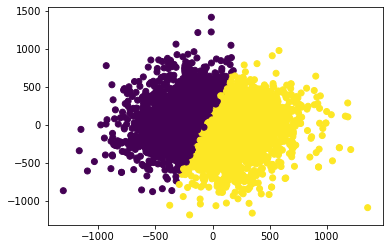

In [59]:
km = KMeans(n_clusters=2)
clusters = km.fit_predict(data_pca_2)
plt.scatter(data_pca_2[:, 0], data_pca_2[:, 1], c=clusters)

In [61]:
km.labels_

array([1, 1, 0, ..., 1, 1, 0])

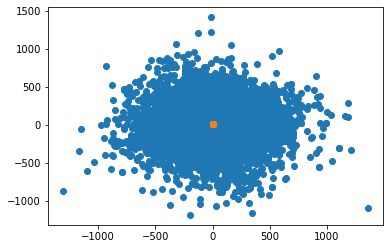

In [55]:
#DBSCAN
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
#model = DBSCAN(eps=0.7, min_samples=6)
model = DBSCAN(eps=0.8, min_samples=7)
yhat = model.fit_predict(data_pca_2)
clusters = unique(yhat)
for cluster in clusters:
    row_ix = where(yhat == cluster)
    pyplot.scatter(data_pca_2[row_ix, 0], data_pca_2[row_ix, 1])
pyplot.show()

DBSCAN does not has a clear boundary

In [70]:
from sklearn import metrics
#Silhouette Score
print(metrics.silhouette_score(data_pca_2, model.labels_))

In [62]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

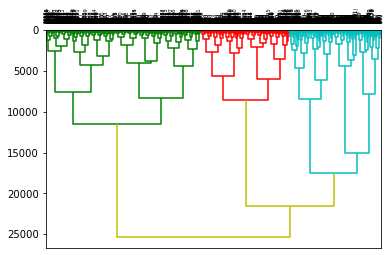

In [64]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(data_pca_2)

Z = linkage(data_pca_2,method= 'ward')
dn1 = dendrogram(Z, p = 10, truncate_mode = 'level', above_threshold_color='y',
                           orientation='bottom')

# Feature selection

In [77]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel

In [78]:
X = data_cleaned.iloc[:,1:]
y = data_cleaned.team_one_win
selector = SelectFromModel(estimator=DecisionTreeClassifier()).fit(X, y)

In [83]:
# selected column by decision tree

decision_select = X.columns[selector.get_support()].tolist()
decision_select

['team_one_first_inhibitor',
 'team_one_assists',
 'team_two_assists',
 'team_one_level',
 'team_two_level',
 'team_one_kills',
 'team_two_kills',
 'team_one_obj_damage',
 'team_two_obj_damage']

In [84]:
from sklearn.ensemble import RandomForestClassifier
selector1 = SelectFromModel(estimator=RandomForestClassifier()).fit(X, y)
rf_select = X.columns[selector1.get_support()].tolist()
rf_select

['duration',
 'team_one_barons',
 'team_two_barons',
 'team_one_dragons',
 'team_two_dragons',
 'team_one_first_baron',
 'team_one_first_inhibitor',
 'team_one_first_tower',
 'team_one_assists',
 'team_two_assists',
 'team_one_level',
 'team_two_level',
 'team_one_kills',
 'team_two_kills',
 'team_one_obj_damage',
 'team_two_obj_damage',
 'team_one_double_kills',
 'team_two_double_kills',
 'team_one_damage',
 'team_two_damage',
 'team_one_enemy_monsters_killed',
 'team_two_enemy_monsters_killed',
 'team_one_healing',
 'team_two_healing',
 'team_one_champ_damage',
 'team_two_champ_damage',
 'team_one_cs',
 'team_two_cs',
 'team_one_vision_score',
 'team_two_vision_score',
 'team_one_top_avg_xp_diff',
 'team_one_jungle_avg_xp_diff',
 'team_one_mid_avg_xp_diff',
 'team_one_bot_avg_xp_diff']

In [86]:
from sklearn.linear_model import RidgeClassifier
selector2 = SelectFromModel(estimator=RidgeClassifier()).fit(X, y)
ridge_select = X.columns[selector2.get_support()].tolist()
ridge_select


['duration',
 'team_one_first_baron',
 'team_one_first_inhibitor',
 'team_one_assists',
 'team_two_assists',
 'team_one_level',
 'team_two_level',
 'team_two_kills',
 'team_one_obj_damage',
 'team_two_obj_damage',
 'team_one_damage',
 'team_two_damage',
 'team_two_cc_time',
 'team_one_healing',
 'team_two_healing',
 'team_one_champ_damage',
 'team_two_champ_damage',
 'team_one_cs',
 'team_two_cs',
 'team_two_vision_score']

In [87]:
from sklearn.ensemble import AdaBoostClassifier
selector3 = SelectFromModel(estimator=AdaBoostClassifier()).fit(X, y)
ada_select = X.columns[selector3.get_support()].tolist()
ada_select

['team_one_dragons',
 'team_one_first_inhibitor',
 'team_one_assists',
 'team_two_assists',
 'team_one_level',
 'team_two_level',
 'team_one_kills',
 'team_two_kills',
 'team_one_obj_damage',
 'team_two_obj_damage',
 'team_one_double_kills',
 'team_two_double_kills',
 'team_two_enemy_monsters_killed',
 'team_one_cs',
 'team_two_cs',
 'team_one_mid_avg_cs_diff',
 'team_one_top_avg_xp_diff',
 'team_one_bot_avg_xp_diff']

# forward feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(knn, n_features_to_select=30).fit(X,y)
forward_select = X.columns[sfs.get_support()].tolist()
forward_select

In [89]:
from sklearn.neighbors import KNeighborsClassifier
selector4 = SelectFromModel(estimator=AdaBoostClassifier()).fit(X, y)
knn_select = X.columns[selector4.get_support()].tolist()
knn_select

['team_one_dragons',
 'team_one_first_inhibitor',
 'team_one_assists',
 'team_two_assists',
 'team_one_level',
 'team_two_level',
 'team_one_kills',
 'team_two_kills',
 'team_one_obj_damage',
 'team_two_obj_damage',
 'team_one_double_kills',
 'team_two_double_kills',
 'team_two_enemy_monsters_killed',
 'team_one_cs',
 'team_two_cs',
 'team_one_mid_avg_cs_diff',
 'team_one_top_avg_xp_diff',
 'team_one_bot_avg_xp_diff']

In [98]:
selector5 = SelectKBest(f_classif, k=20).fit(X, y)
f_select = X.columns[selector5.get_support()].tolist()
f_select

['team_one_barons',
 'team_two_barons',
 'team_one_dragons',
 'team_two_dragons',
 'team_one_first_baron',
 'team_one_first_inhibitor',
 'team_one_first_tower',
 'team_one_assists',
 'team_two_assists',
 'team_one_kills',
 'team_two_kills',
 'team_one_obj_damage',
 'team_two_obj_damage',
 'team_one_double_kills',
 'team_two_double_kills',
 'team_one_enemy_monsters_killed',
 'team_two_enemy_monsters_killed',
 'team_one_jungle_avg_xp_diff',
 'team_one_mid_avg_xp_diff',
 'team_one_bot_avg_xp_diff']

In [100]:
selected_feature = list(set(decision_select + rf_select + ridge_select + ada_select + knn_select + f_select))

In [103]:
len(selected_feature)

36

In [105]:
data_cleaned[['team_one_win'] + selected_feature].to_csv("data_featureselection.csv", index=False)